In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dropout, Dense, Activation, Conv1D, GlobalMaxPooling1D, MaxPooling1D, concatenate, Flatten, Reshape
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras import Input

import datetime
import os

In [84]:
## 하이퍼 파라메터

delta = 1e-7
seq_len = 30
test_date = 304
factor_num = 4

level_1 = 30
level_2 = 80
level_3 = 150

num_level = 4

pm_target = level_3 * 2
temp_target = 24 * 2
humidity_target = 100
wind_speed_target = 14 # 강한 바람
wind_direction_target = 360*2 # 16방위

year = 365
train_cut = year * 9 + 1 -30

test_cut = -test_date


In [85]:
## 데이터 로드
data = pd.read_csv('dataset/PM_2.5_dataset_09_19.csv', index_col=0)
data.head()

,PM Seoul,PM Beijing,avg temprature,avg humidity,avg wind speed seoul,max wind direction seoul,avg wind speed back,max wind direction back
date,,,,,,,,
2009-01-01,43.739130,181.083875,-5.8,45.8,2.3,290,4.5,320
2009-01-02,45.750000,168.780998,-2.8,51.5,1.6,290,4.2,320
2009-01-03,46.833333,177.560185,-1.0,48.3,1.8,20,2.8,320
2009-01-04,40.083333,169.828704,0.4,44.3,1.9,290,3.1,290
2009-01-05,58.541667,140.598765,-1.6,53.1,2.2,290,5.0,290


In [122]:
## 초기 데이터 입력

pm_seoul_data = data['PM Seoul'].values
pm_beijing_data = data['PM Beijing'].values
temp_data = data['avg temprature'].values
humidity_data = data['avg humidity'].values
wind_speed_seoul_data = data['avg wind speed seoul'].values
wind_direction_seoul_data = data['max wind direction seoul'].values
wind_speed_back_data = data['avg wind speed back'].values
wind_direction_back_data = data['max wind direction back'].values

In [123]:
## 시계열 함수
def make_sequential(data):
    for i in range(len(data)):
        if data[i] == 0:
            data[i] = data[i]+delta
        
    sequence_length = seq_len + 1
    
    temp_data = []
    for index in range((len(data) - sequence_length)+1):
        temp_data.append(data[index: index + sequence_length])
        
    return np.array(temp_data)

In [124]:
def pm_norm_window(data):
    norm_data = []
    
    for i in range(len(data)):
        norm_data.append(data[i] / pm_target)
        
    return norm_data

In [125]:
def temp_norm_window(data):
    norm_data = []
    
    for i in range(len(data)):
        norm_data.append((data[i] / temp_target)**2)
        
    return norm_data

In [126]:
def humidity_norm_window(data):
    norm_data = []
    
    for i in range(len(data)):
        norm_data.append((data[i] / humidity_target)**2)
        
    return norm_data

In [127]:
def wind_speed_norm_window(data):
    norm_data = []
    
    for i in range(len(data)):
        norm_data.append(data[i] / wind_speed_target)
        
    return norm_data

In [128]:
def wind_direction_norm_window(data):
    norm_data = []
    
    for i in range(len(data)):
        norm_data.append((data[i] / wind_direction_target)**2)
        
    return norm_data

In [129]:
norm_pm_seoul = make_sequential(pm_norm_window(pm_seoul_data))
norm_pm_beijing = make_sequential(pm_norm_window(pm_beijing_data))
norm_temp = make_sequential(temp_norm_window(temp_data))
norm_humidity = make_sequential(humidity_norm_window(humidity_data))
norm_wind_speed_seoul = make_sequential(wind_speed_norm_window(wind_speed_seoul_data))
norm_wind_speed_back = make_sequential(wind_speed_norm_window(wind_speed_back_data))
norm_wind_direction_seoul = make_sequential(wind_direction_norm_window(wind_direction_seoul_data))
norm_wind_direction_back = make_sequential(wind_direction_norm_window(wind_direction_back_data))

In [137]:
## 병합함수

def marge_data(a, b, c, d, e, f, g, h):
    marged_data = []
    marge = []
    
    for a_index, b_index, c_index, d_index, e_index, f_index, g_index, h_index in zip(a, b, c, d, e, f, g, h):
        for i in range(len(a_index)):
            marge.append(a_index[i])
            marge.append(b_index[i])
            #marge.append(c_index[i])
            #marge.append(d_index[i])
            marge.append(e_index[i])
            marge.append(f_index[i])
            #marge.append(g_index[i])
            #marge.append(h_index[i])
            
        for i in range(factor_num-1):
            marge.pop()
        
        marged_data.append(marge)
        marge = []
    
    return np.array(marged_data)

norm_result = marge_data(norm_pm_seoul, norm_pm_beijing, norm_temp, norm_humidity, norm_wind_speed_seoul, 
                         norm_wind_direction_seoul, norm_wind_speed_back, norm_wind_direction_back)


In [131]:

train = norm_result[:train_cut, :]
np.random.shuffle(train)

valid = norm_result[train_cut:test_cut, :]
#np.random.shuffle(valid)

test = norm_result[test_cut:, :]

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:,-1]
y_train = np.reshape(y_train, (y_train.shape[0], 1))

x_valid = valid[:, :-1]
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))
y_valid = valid[:,-1]
y_valid = np.reshape(y_valid, (y_valid.shape[0], 1))

x_test = test[:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = test[:,-1]
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(3256, 120, 1) (366, 120, 1) (304, 120, 1)
(3256, 1) (366, 1) (304, 1)


### 모델 체크포인터 롤백
MODEL_SAVE_FOLBER_PATH = './model/checkpoint_archi_5/'
if not os.path.exists(MODEL_SAVE_FOLBER_PATH):
    os.mkdir(MODEL_SAVE_FOLBER_PATH)
    
model_path = MODEL_SAVE_FOLBER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'

# 체크포인트 생성 코드
cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',verbose=1, save_best_only=True, mode='auto')

In [14]:
### LCRNN 모델 설계
model = Sequential()


model.add(Conv1D(32, 2, activation='linear',strides=2, input_shape=(seq_len*factor_num,1)))
model.add(Conv1D(64, 2, activation='linear',strides=2))
model.add(Conv1D(128, 1, activation='linear',strides=1))

# model.add(Conv1D(60, 3, activation='relu',strides=1, padding="same"))
for i in range (2):
    model.add(LSTM(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))


model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.summary()

W1122 18:18:42.587820 18736 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1122 18:18:42.603825 18736 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1122 18:18:42.605825 18736 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1122 18:18:42.728784 18736 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1122 18:18:42.734787 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 60, 32)            96        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 64)            4160      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 30, 128)           8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total para

## 콜백 리스트 - 정해진 에폭동안 모니터링 지표가 향상되지 않으면 훈련을 중지
callback_list = [
    keras.callbacks.EarlyStooping(
        monitor='val_acc', patience=1,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='model/checkpoint/temp_model.h5',
        moitor='val_loss',
        save_best_only=True,
    )
]

## 검증손실이 향상되지 않을때 학습율을 작게함
callback_list = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1, # 콜백 호출시 학습률을 10배로 줄인다.
    patience=5,
    )
]

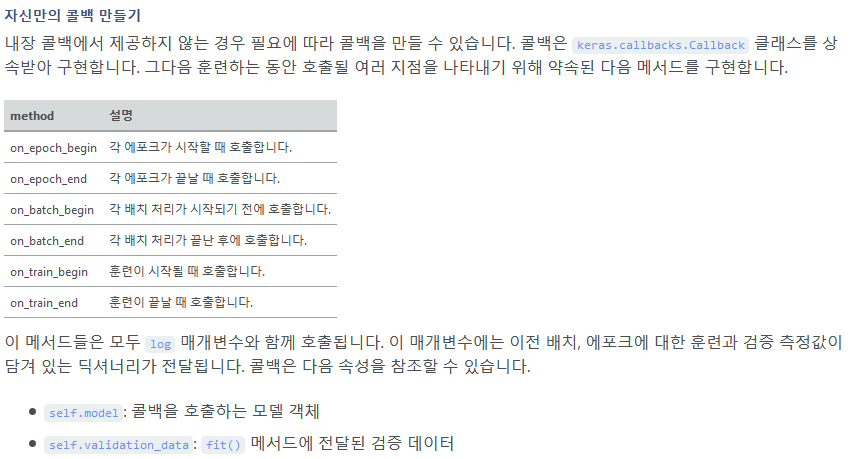

In [15]:
### 모델 학습
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.compile(loss='mse', optimizer='adam')


hist = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=50, batch_size=100)
#hist = model.fit(x_train_dict, y_train, validation_data=(x_valid_dict, y_valid), epochs=20, batch_size=100)

W1122 18:18:58.458752 18736 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1122 18:18:58.644690 18736 deprecation.py:323] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1122 18:19:00.389143 18736 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 3256 samples, validate on 366 samples
Epoch 1/50
3256/3256 [==============================] - 10s 3ms/step - loss: 0.0119 - val_loss: 0.0041
Epoch 2/50
3256/3256 [==============================] - 6s 2ms/step - loss: 0.0089 - val_loss: 0.0040
Epoch 3/50
3256/3256 [==============================] - 5s 2ms/step - loss: 0.0086 - val_loss: 0.0045
Epoch 4/50
3256/3256 [==============================] - 6s 2ms/step - loss: 0.0084 - val_loss: 0.0037
Epoch 5/50
3256/3256 [==============================] - 5s 2ms/step - loss: 0.0083 - val_loss: 0.0035
Epoch 6/50
3256/3256 [==============================] - 5s 2ms/step - loss: 0.0082 - val_loss: 0.0045
Epoch 7/50
3256/3256 [==============================] - 6s 2ms/step - loss: 0.0079 - val_loss: 0.0034
Epoch 8/50
3256/3256 [==============================] - 6s 2ms/step - loss: 0.0078 - val_loss: 0.0030
Epoch 9/50
3256/3256 [==============================] - 5s 2ms/step - loss: 0.0077 - val_loss: 0.0032
Epoch 10/50
3256/3256 [===========

## 모델 저장
model.save('model/PM Prediction using LCRNN with four factors sdbd.h5')

In [91]:
model = load_model('model/PM Prediction using LCRNN with four factors.h5')

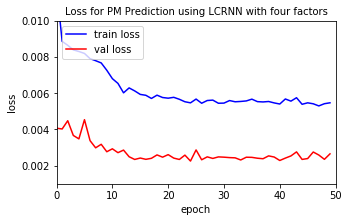

In [92]:
## 손실함수 변화 측정
fig = plt.figure(facecolor='white', figsize=(5, 3))
loss_ax = fig.add_subplot(111)

loss_ax.plot(hist.history['loss'], 'b', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.1, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.title('Loss for PM Prediction using LCRNN with four factors', fontsize=10)

plt.xlim([0, 50])
plt.ylim([0.001, 0.01])

plt.show()

In [138]:
## 결과 실제화
y_true = pm_seoul_data[test_cut:]

pred = model.predict(x_test)

y_pred = pred * pm_target

D:\_setup\anaconda3\envs\py3.7\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


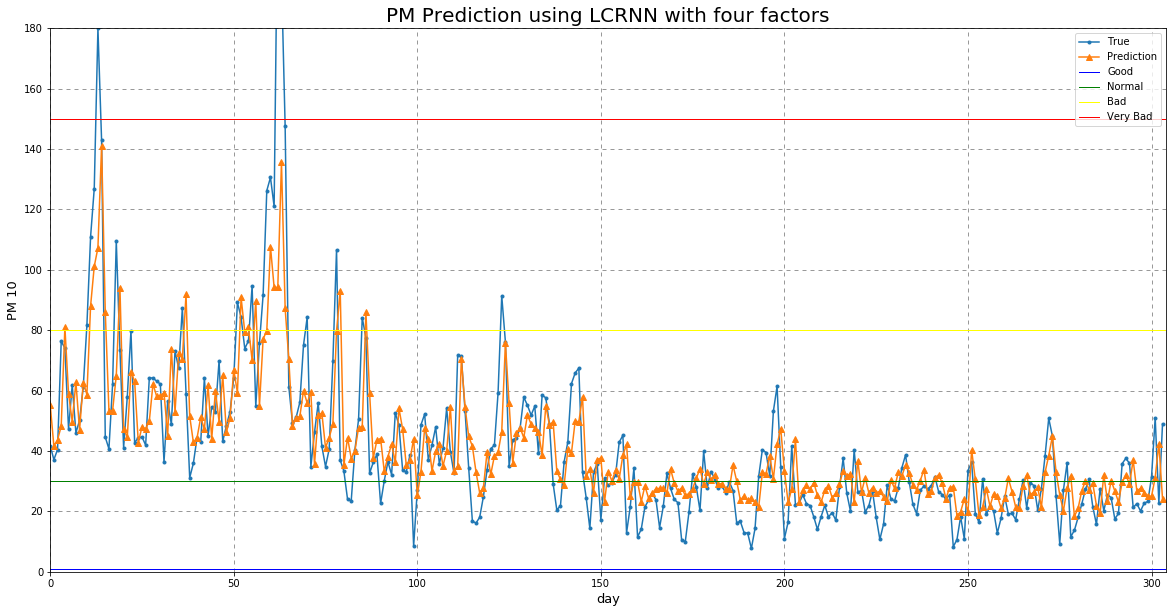

In [139]:
fig = plt.figure(facecolor='white', figsize=(20, 10))

plt.title('PM Prediction using LCRNN with four factors', fontsize=20)

ax = fig.add_subplot(111)
ax.plot(y_true, label='True', marker='.')
ax.plot(y_pred, label='Prediction', marker='^')

plt.grid(color='gray', dashes=(5,5))

plt.axhline(y=1, color='blue', linewidth=1, label='Good')
plt.axhline(y=level_1, color='green', linewidth=1, label='Normal')
plt.axhline(y=level_2, color='yellow', linewidth=1, label='Bad')
plt.axhline(y=level_3, color='red', linewidth=1, label='Very Bad')

plt.xlabel('day', fontsize=13)
plt.ylabel('PM 10', fontsize=13)

plt.xlim([0, test_date])
plt.ylim([0, 180])

ax.legend()
plt.show()

In [140]:
## 단계별 정확도 및 총 정확도 계산 함수
def pm_level(pm):
    
    level_temp = []
    
    for i in range(len(pm)):
        if pm[i] <= level_1:
            level_temp.append(1)
        elif pm[i] <= level_2:
            level_temp.append(2)
        elif pm[i] <= level_3:
            level_temp.append(3)
        else:
            level_temp.append(4)
            
    return level_temp
    

In [141]:
def error_check(true, pred):
    y_true_lv = pm_level(true)
    y_pred_lv = pm_level(pred)
    
    level_1_acc = 0
    level_2_acc = 0
    level_3_acc = 0
    level_4_acc = 0

    level_1_count = y_true_lv.count(1)
    level_2_count = y_true_lv.count(2)
    level_3_count = y_true_lv.count(3)
    level_4_count = y_true_lv.count(4)
            
    
    error_rate_temp = []
    
    for i in range(len(y_pred_lv)):
        if y_pred_lv[i] == y_true_lv[i]:
            error_rate_temp.append(1)
            
            if y_pred_lv[i] == 1:
                level_1_acc += 1
            elif y_pred_lv[i] == 2:
                level_2_acc += 1
            elif y_pred_lv[i] == 3:
                level_3_acc += 1
            else:
                level_4_acc += 1
                    
        else:
            error_rate_temp.append(0)
    
    total_acc = sum(error_rate_temp) / len(error_rate_temp)
    
    
    level_1_accuracy = float(level_1_acc / level_1_count)
    level_2_accuracy = float(level_2_acc / level_2_count)
    level_3_accuracy = float(level_3_acc / level_3_count)
    level_4_accuracy = float(level_4_acc / level_4_count)
    
    level_accuracy = [level_1_accuracy,level_2_accuracy, level_3_accuracy, level_4_accuracy]
    
    return total_acc, level_accuracy


In [142]:
## 정확도 결과
total_acc, level_acc = error_check(y_true, y_pred)
print("total accuracy:", total_acc)
print("level 'Good' accuracy:", level_acc[0])
print("level 'Normal' accuracy:", level_acc[1])
print("level 'Bad' accuracy:", level_acc[2])
print("level 'Very Bad' accuracy:", level_acc[3])

total accuracy: 0.7236842105263158
level 'Good' accuracy: 0.6692307692307692
level 'Normal' accuracy: 0.8235294117647058
level 'Bad' accuracy: 0.3888888888888889
level 'Very Bad' accuracy: 0.0
